# Missing patterns
Similar to the last section, we will now look at the $\texttt{FIM}$ model. We will again generate some data, write some preprocessing function and delve deeper into the arguments of this model! Remember that the $\texttt{FIM}$ tries to impute a whole range of values over some timeframe for which local simplicity can no longer be assumed.

In [66]:
from fim.models.imputation import FIMImputationWindowed
import torch
model = FIMImputationWindowed.from_pretrained("FIM4Science/fim-windowed-imputation")

## Imputing a pattern
We again start by generating some data, similar to the last two sections:

In [67]:
ts = (torch.arange(0, 10, step=0.1) - 3).reshape(1, 1, 100, 1)
true_values= torch.sin(2*ts) - ts 
noisy_values = true_values + torch.normal(0, 2.5, size=true_values.shape)

Sadly the function needed to prepare our data for this model is a bit more lengthy. New users can either use this version, which assumes 3 windows (Start window, Imputation window, End Window), the version from ```tutorial_help.py``` which also supports 5 windows or write their own preprocessing function. This function then should follow the structure of the output of this function, i.e. a dictionary with the same keys and the described dimensions! The output should therefore have the following keys with the indicated shapes, where wc is the window count, B the batch size and D the dimension:

|  Key  | Shape |
| ----- | ----- |
|location_times | [B, wlen_locs, 1] | 
|observation_times | [B, wc, wlen, D] | 
|observation_values | [B, wc, wlen, D] | 
|observation_mask | [B, wc, wlen, D] | 
|linitial_conditions | [B, D] | 
|rinitial_conditions | [B, D] | 
| padding_mask_locations | [B, wlen_locs] |

In [68]:
def prepare_data_3_window(ts, values, mask=None, imp_start=65, imp_end=70):
    """
    Prepare simple time series data for FIM imputation model.
    
    Args:
        ts: Time points tensor of shape [1, 1, T, 1]
        values: Value tensor of shape [1, 1, T, 1] 
        mask: Boolean mask tensor of shape [1, 1, T, 1] (True = observed, False = missing)
        window_count: Number of windows (3 or 5)
        imputation_start: Start index for imputation window
        imputation_end: End index for imputation window
    
    Returns:
        batch: Dictionary suitable for FIM model
    """
    if mask is None:
        mask = torch.zeros_like(ts).bool()
    
    B, _, T, D = ts.shape  # Should be [1, 1, T, 1]
    
    
    # Create location times and values (imputation window)
    loc_times = ts[0, 0, imp_start:imp_end].unsqueeze(0)  # [1, imp_len, 1]
    loc_values = values[0, 0, imp_start:imp_end].unsqueeze(0)  # [1, imp_len, 1]
    
    # Create context windows

    # Left context, imputation window (index 1), right context
    left_context_values = values[:, :, :imp_start]  # [1, 1, left_len, 1]
    right_context_values = values[:, :, imp_end:]   # [1, 1, right_len, 1]
    
    left_context_times = ts[:, :, :imp_start]
    right_context_times = ts[:, :, imp_end:]
    
    left_context_mask = mask[:, :, :imp_start]
    right_context_mask = mask[:, :, imp_end:]
    
    # Pad to same length (max_length_window)
    max_len = max(left_context_values.shape[2], right_context_values.shape[2])
    max_len = max(max_len, 64)  # Minimum window size
    
    # Pad left context
    left_pad_size = max_len - left_context_values.shape[2]
    if left_pad_size > 0:
        left_context_values = torch.cat([
            torch.zeros(B, 1, left_pad_size, D), 
            left_context_values
        ], dim=2)
        left_context_times = torch.cat([
            torch.zeros(B, 1, left_pad_size, 1), 
            left_context_times
        ], dim=2)
        left_context_mask = torch.cat([
            torch.zeros(B, 1, left_pad_size, 1, dtype=torch.bool), 
            left_context_mask
        ], dim=2)
    else:
        # Truncate if too long
        left_context_values = left_context_values[:, :, -max_len:]
        left_context_times = left_context_times[:, :, -max_len:]
        left_context_mask = left_context_mask[:, :, -max_len:]
    
    # Pad right context
    right_pad_size = max_len - right_context_values.shape[2]
    if right_pad_size > 0:
        right_context_values = torch.cat([
            right_context_values,
            torch.zeros(B, 1, right_pad_size, D)
        ], dim=2)
        right_context_times = torch.cat([
            right_context_times,
            torch.zeros(B, 1, right_pad_size, 1)
        ], dim=2)
        right_context_mask = torch.cat([
            right_context_mask,
            torch.zeros(B, 1, right_pad_size, 1, dtype=torch.bool)
        ], dim=2)
    else:
        # Truncate if too long
        right_context_values = right_context_values[:, :, :max_len]
        right_context_times = right_context_times[:, :, :max_len]
        right_context_mask = right_context_mask[:, :, :max_len]
    
    # Stack context windows: [B, window_count-1, max_len, D]
    context_values = torch.stack([left_context_values.squeeze(1), right_context_values.squeeze(1)], dim=1)
    context_times = torch.stack([left_context_times.squeeze(1), right_context_times.squeeze(1)], dim=1)
    context_mask = torch.stack([left_context_mask.squeeze(1), right_context_mask.squeeze(1)], dim=1)
        
    
    
    # Find initial conditions (last observed point in left context, first in right context)
    # Find last True in left context
    left_mask = context_mask[:, 0].squeeze(-1)  # [B, max_len]
    reversed_left = torch.flip(left_mask, dims=[1])
    last_idx_left = torch.argmax(reversed_left.int(), dim=1)
    last_idx_left = left_mask.shape[1] - 1 - last_idx_left
    
    # Find first True in right context
    right_mask = context_mask[:, 1].squeeze(-1)  # [B, max_len]
    first_idx_right = torch.argmax(right_mask.int(), dim=1)
    
    batch_indices = torch.arange(B)
    linitial_conditions = context_values[:, 0][batch_indices, last_idx_left]  # [B, D]
    rinitial_conditions = context_values[:, 1][batch_indices, first_idx_right]  # [B, D]
    
    # Create padding mask for locations (all False for no padding in this simple case)
    padding_mask_locations = torch.zeros(B, loc_times.shape[1], dtype=torch.bool)
    
    # Prepare batch dictionary
    batch = {
        "location_times": loc_times.float(),
        "target_sample_path": loc_values.float(),
        "initial_conditions": loc_values[:, 0].float(),  # First point of imputation window
        "observation_values": context_values.float(),
        "linitial_conditions": linitial_conditions.float(),
        "rinitial_conditions": rinitial_conditions.float(),
        "observation_mask": context_mask, 
        "observation_times": context_times.float(),
        "padding_mask_locations": padding_mask_locations,
    }
    
    return batch

With all that hard work, we can now impute the missing values as before:

In [69]:
mask = torch.zeros_like(ts).bool()
mask[0,0,[i for i in range(70,80)],0]=True # Mask out the values we want to impute
batch=prepare_data_3_window(ts,true_values,mask,imp_start=70,imp_end=80)
with torch.no_grad():
    prediction=model(batch)["imputation_window"]["learnt"].flatten()

Similar to the model, the FIM returns more then just the learned values, here is a complete list of the structure of the output:
```
{
    "imputation_window": {
        "learnt": learnt_imp_solution,
        "target": batch.get("target_sample_path", None),
        "locations": locations,
        "drift": learnt_imp_drift,
        "drift_certainty": learnt_imp_certainty,
        "padding_mask_locations": batch.get("padding_mask_locations", None),
    },
    "observations": {
        "values": obs_values,
        "mask": obs_mask,
        "times": obs_times,
        "denoised_values": obs_values_processed.view(B, wc, wlen, D),
        "interpolation": interpolation_solution,
        "drift": interpolation_drift,
        "drift_certainty": interpolation_certainty,
    },
}
```

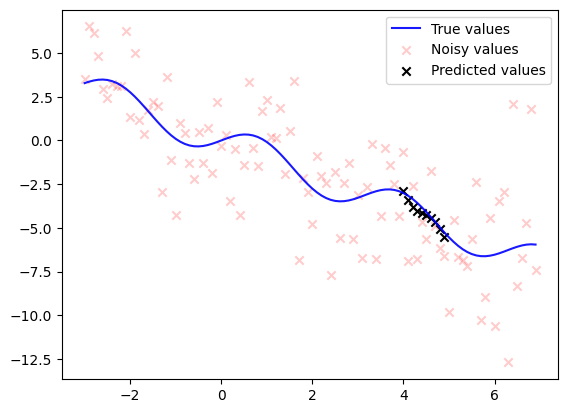

In [70]:
import matplotlib.pyplot as plt
plt.plot(ts.flatten(), true_values.flatten(), label="True values", c="blue",alpha=0.9)
plt.scatter(ts.flatten(), noisy_values.flatten(), label="Noisy values",  c="red",marker="x", alpha=0.2)
plt.scatter(ts.flatten()[mask.flatten()], prediction, label="Predicted values", c="black", marker="x")
plt.legend()
plt.show()